In [2]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  Cell 1 – Install & import                                     ║
# ╚════════════════════════════════════════════════════════════════╝
!pip -q install datasets spacy networkx nltk matplotlib
!python -m spacy download en_core_web_sm -q

from datasets               import load_dataset
import matplotlib.pyplot    as plt
import networkx             as nx
import spacy, re, nltk, collections, itertools, math, json
nltk.download("punkt")
nlp = spacy.load("en_core_web_sm")



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
zsh:1: command not found: python


[nltk_data] Downloading package punkt to /Users/ShaniStu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# ╔═══════════════════════════════════════════════════════════════╗
# ║  Cell 2 – Load dataset                                        ║
# ╚═══════════════════════════════════════════════════════════════╝
DATASET = "kjgpta/WhoDunIt"
ds      = load_dataset(DATASET, split="train")      # 400 items
print(ds.column_names)
print(f"{len(ds):,} stories loaded.")


['title', 'author', 'length', 'culprit_ids', 'text', 'metadata']
320 stories loaded.


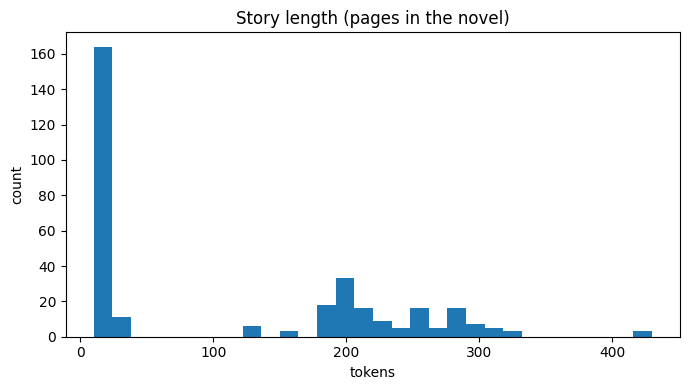

In [4]:
# ╔═══════════════════════════════════════════════════════════════╗
# ║  Cell 3 – Reality-check #1: story length histogram            ║
# ╚═══════════════════════════════════════════════════════════════╝
token_counts = [ex["length"]          # length already provided
                for ex in ds]

plt.figure(figsize=(7,4))
plt.hist(token_counts, bins=30)
plt.title("Story length (pages in the novel)")
plt.xlabel("tokens"); plt.ylabel("count")
plt.tight_layout(); plt.show()


In [1]:
import matplotlib.pyplot as plt
from collections import Counter

def count_culprits(entry):
    """Count the number of culprits in each story"""
    # Check for different possible field names
    culprit_field = None
    for field_name in ["culprit_ids", "culprits", "culprit", "suspects"]:
        if field_name in entry:
            culprit_field = entry[field_name]
            break
    
    if culprit_field is None:
        return {"culprit_count": 0}
    
    # Handle different data types
    if isinstance(culprit_field, list):
        # If it's a list of strings, count words in each string
        if all(isinstance(item, str) for item in culprit_field):
            total_names = sum(len(c.strip().split()) for c in culprit_field if c.strip())
            return {"culprit_count": total_names}
        # If it's a list of other types, just count the items
        else:
            return {"culprit_count": len(culprit_field)}
    
    elif isinstance(culprit_field, str):
        # If it's a single string, count words
        return {"culprit_count": len(culprit_field.strip().split()) if culprit_field.strip() else 0}
    
    elif isinstance(culprit_field, (int, float)):
        # If it's already a number
        return {"culprit_count": int(culprit_field)}
    
    else:
        return {"culprit_count": 0}

# Apply the counting function to the correct dataset variable (ds)
ds_with_counts = ds.map(count_culprits)

# Extract culprit counts safely
try:
    # Method 1: If dataset supports direct column access
    culprit_counts = ds_with_counts["culprit_count"]
except (KeyError, TypeError):
    try:
        # Method 2: Extract from each example
        culprit_counts = [example["culprit_count"] for example in ds_with_counts]
    except (KeyError, TypeError):
        # Method 3: Fallback - recompute counts
        culprit_counts = []
        for example in ds_with_counts:
            result = count_culprits(example)
            culprit_counts.append(result["culprit_count"])

# Remove any None values and ensure all are integers
culprit_counts = [int(count) for count in culprit_counts if count is not None]

print(f"Culprit count statistics:")
print(f"  Total stories: {len(culprit_counts)}")
print(f"  Min culprits: {min(culprit_counts) if culprit_counts else 0}")
print(f"  Max culprits: {max(culprit_counts) if culprit_counts else 0}")
print(f"  Average culprits: {sum(culprit_counts)/len(culprit_counts):.2f}" if culprit_counts else "N/A")

# Create the histogram
if culprit_counts:
    max_count = max(culprit_counts)
    
    plt.figure(figsize=(10, 6))
    
    # Create bins that make sense for the data
    if max_count <= 10:
        bins = range(0, max_count + 2)
        plt.hist(culprit_counts, bins=bins, align='left', 
                edgecolor='black', color='salmon', alpha=0.7)
    else:
        # For larger ranges, use automatic binning
        plt.hist(culprit_counts, bins=20, edgecolor='black', 
                color='salmon', alpha=0.7)
    
    plt.title("Distribution of Number of Culprits per Story", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Named Culprits")
    plt.ylabel("Number of Stories")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    
    # Add some statistics to the plot
    avg_culprits = sum(culprit_counts) / len(culprit_counts)
    plt.axvline(avg_culprits, color='red', linestyle='--', alpha=0.8, 
                label=f'Average: {avg_culprits:.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show distribution breakdown
    count_distribution = Counter(culprit_counts)
    print(f"\nCulprit count distribution:")
    for count in sorted(count_distribution.keys()):
        stories = count_distribution[count]
        percentage = (stories / len(culprit_counts)) * 100
        print(f"  {count} culprits: {stories} stories ({percentage:.1f}%)")

else:
    print("No culprit count data found to plot")

# Optional: Show some examples of the culprit data
print(f"\nSample culprit data from first 5 stories:")
for i in range(min(5, len(ds_with_counts))):
    example = ds_with_counts[i]
    title = example.get('title', f'Story {i+1}')
    
    # Check what culprit fields exist
    culprit_info = []
    for field in ['culprit_ids', 'culprits', 'culprit', 'suspects']:
        if field in example:
            culprit_info.append(f"{field}: {example[field]}")
    
    culprit_count = example.get('culprit_count', 'N/A')
    print(f"  Story {i+1} ({title}): {culprit_count} culprits")
    if culprit_info:
        print(f"    Raw data: {'; '.join(culprit_info[:2])}")  # Show first 2 fields

NameError: name 'ds' is not defined

Culprit count statistics:
  Total stories: 320
  Min culprits: 1
  Max culprits: 6
  Average culprits: 2.34


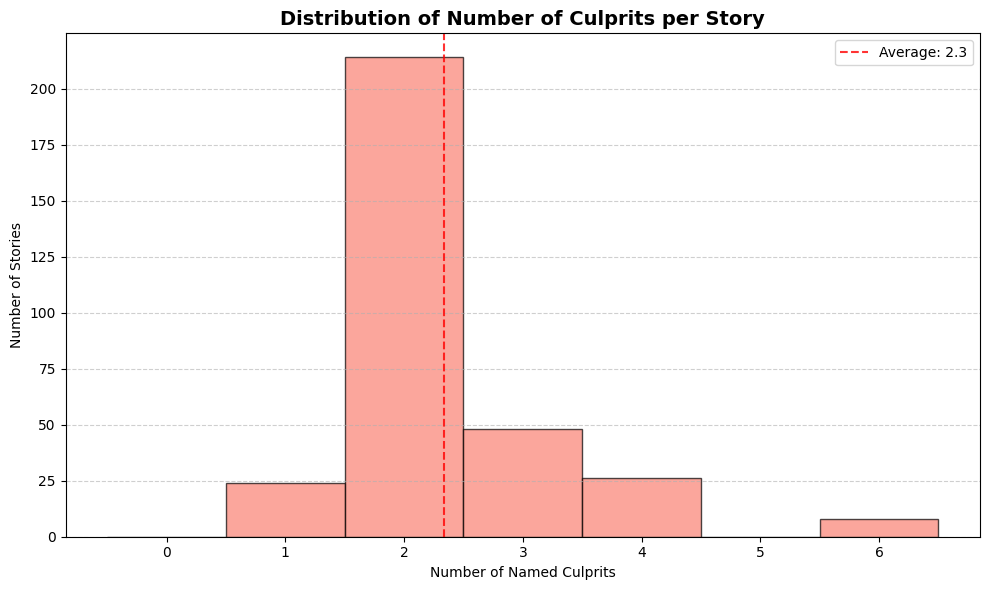


Culprit count distribution:
  1 culprits: 24 stories (7.5%)
  2 culprits: 214 stories (66.9%)
  3 culprits: 48 stories (15.0%)
  4 culprits: 26 stories (8.1%)
  6 culprits: 8 stories (2.5%)

Sample culprit data from first 5 stories:
  Story 1 (The D'Arblay Mystery): 3 culprits
    Raw data: culprit_ids: ['thorndyke gray', 'dewsnep']
  Story 2 (The Final Problem): 1 culprits
    Raw data: culprit_ids: ['slytherin']
  Story 3 (The Adventure of the Blue Carbuncle): 2 culprits
    Raw data: culprit_ids: ['saldana barrymore']
  Story 4 (The Naval Treaty): 2 culprits
    Raw data: culprit_ids: ['annie hudson']
  Story 5 (The Adventure of the Blue Carbuncle): 2 culprits
    Raw data: culprit_ids: ['windigate ryder']


In [2]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load dataset (assuming this is already done)
dataset = load_dataset("kjgpta/WhoDunIt", split="train")

def count_culprits(entry):
    """Count the number of culprits in each story"""
    # Check for different possible field names
    culprit_field = None
    for field_name in ["culprit_ids", "culprits", "culprit", "suspects"]:
        if field_name in entry:
            culprit_field = entry[field_name]
            break
    
    if culprit_field is None:
        return {"culprit_count": 0}
    
    # Handle different data types
    if isinstance(culprit_field, list):
        # If it's a list of strings, count words in each string
        if all(isinstance(item, str) for item in culprit_field):
            total_names = sum(len(c.strip().split()) for c in culprit_field if c.strip())
            return {"culprit_count": total_names}
        # If it's a list of other types, just count the items
        else:
            return {"culprit_count": len(culprit_field)}
    
    elif isinstance(culprit_field, str):
        # If it's a single string, count words
        return {"culprit_count": len(culprit_field.strip().split()) if culprit_field.strip() else 0}
    
    elif isinstance(culprit_field, (int, float)):
        # If it's already a number
        return {"culprit_count": int(culprit_field)}
    
    else:
        return {"culprit_count": 0}

# Apply the counting function
dataset = dataset.map(count_culprits)

# Extract culprit counts safely
try:
    # Method 1: If dataset supports direct column access
    culprit_counts = dataset["culprit_count"]
except (KeyError, TypeError):
    try:
        # Method 2: Extract from each example
        culprit_counts = [example["culprit_count"] for example in dataset]
    except (KeyError, TypeError):
        # Method 3: Fallback - recompute counts
        culprit_counts = []
        for example in dataset:
            result = count_culprits(example)
            culprit_counts.append(result["culprit_count"])

# Remove any None values and ensure all are integers
culprit_counts = [int(count) for count in culprit_counts if count is not None]

print(f"Culprit count statistics:")
print(f"  Total stories: {len(culprit_counts)}")
print(f"  Min culprits: {min(culprit_counts) if culprit_counts else 0}")
print(f"  Max culprits: {max(culprit_counts) if culprit_counts else 0}")
print(f"  Average culprits: {sum(culprit_counts)/len(culprit_counts):.2f}" if culprit_counts else "N/A")

# Create the histogram
if culprit_counts:
    max_count = max(culprit_counts)
    
    plt.figure(figsize=(10, 6))
    
    # Create bins that make sense for the data
    if max_count <= 10:
        bins = range(0, max_count + 2)
        plt.hist(culprit_counts, bins=bins, align='left', 
                edgecolor='black', color='salmon', alpha=0.7)
    else:
        # For larger ranges, use automatic binning
        plt.hist(culprit_counts, bins=20, edgecolor='black', 
                color='salmon', alpha=0.7)
    
    plt.title("Distribution of Number of Culprits per Story", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Named Culprits")
    plt.ylabel("Number of Stories")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    
    # Add some statistics to the plot
    avg_culprits = sum(culprit_counts) / len(culprit_counts)
    plt.axvline(avg_culprits, color='red', linestyle='--', alpha=0.8, 
                label=f'Average: {avg_culprits:.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show distribution breakdown
    from collections import Counter
    count_distribution = Counter(culprit_counts)
    print(f"\nCulprit count distribution:")
    for count in sorted(count_distribution.keys()):
        stories = count_distribution[count]
        percentage = (stories / len(culprit_counts)) * 100
        print(f"  {count} culprits: {stories} stories ({percentage:.1f}%)")

else:
    print("No culprit count data found to plot")

# Optional: Show some examples of the culprit data
print(f"\nSample culprit data from first 5 stories:")
for i in range(min(5, len(dataset))):
    example = dataset[i]
    title = example.get('title', f'Story {i+1}')
    
    # Check what culprit fields exist
    culprit_info = []
    for field in ['culprit_ids', 'culprits', 'culprit', 'suspects']:
        if field in example:
            culprit_info.append(f"{field}: {example[field]}")
    
    culprit_count = example.get('culprit_count', 'N/A')
    print(f"  Story {i+1} ({title}): {culprit_count} culprits")
    if culprit_info:
        print(f"    Raw data: {'; '.join(culprit_info[:2])}")  # Show first 2 fields

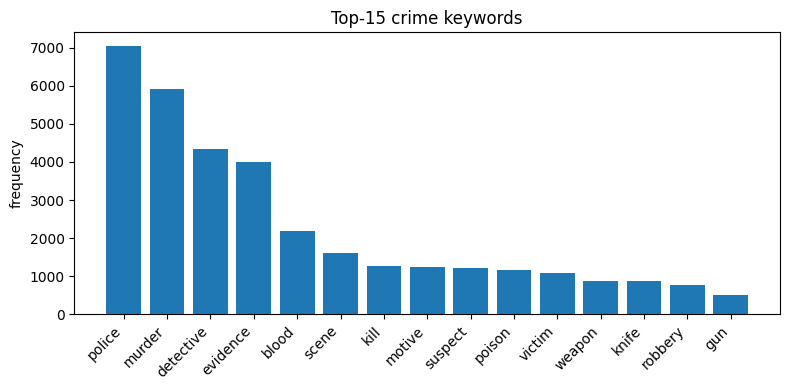

In [6]:
# ╔═══════════════════════════════════════════════════════════════╗
# ║  Cell 4 – Reality-check #2: top crime keywords                ║
# ╚═══════════════════════════════════════════════════════════════╝
CRIME_WORDS = {
    "murder","kill","knife","gun","poison","blood","alibi",
    "motive","weapon","police","detective","victim",
    "scene","corpse","suspect","evidence","robbery"
}

counter = collections.Counter()
for ex in ds:
    words = re.findall(r"\b\w+\b", ex["text"].lower())
    counter.update(w for w in words if w in CRIME_WORDS)

labels, freqs = zip(*counter.most_common(15))
plt.figure(figsize=(8,4))
plt.bar(labels, freqs)
plt.xticks(rotation=45, ha="right")
plt.title("Top-15 crime keywords")
plt.ylabel("frequency")
plt.tight_layout(); plt.show()


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Found 320 stories with both length and culprit count data


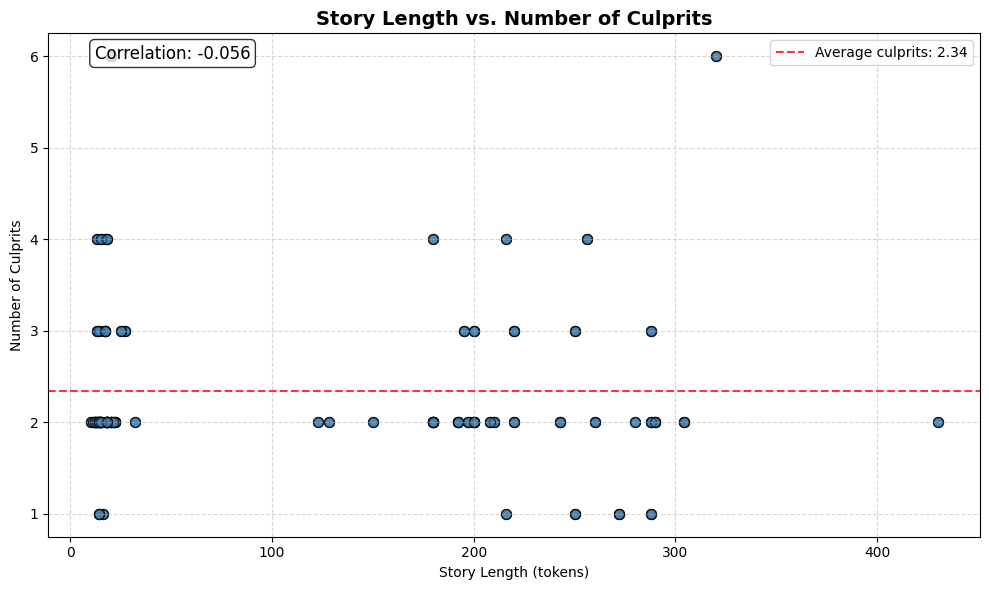


Summary Statistics:
  Stories analyzed: 320
  Length range: 10 to 430 tokens
  Culprit range: 1 to 6 culprits
  Average culprits per story: 2.34
  Correlation coefficient: -0.056


In [8]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  Cell X – Scatter Plot: Story Length vs. Number of Culprits   ║
# ╚════════════════════════════════════════════════════════════════╝

# First, let's make sure we have the culprit_count field in our dataset
# Apply the count_culprits function to our original dataset
ds_with_counts = ds.map(count_culprits)

# Extract story lengths and culprit counts
story_lengths = []
culprit_counts_scatter = []

for ex in ds_with_counts:
    if "length" in ex and "culprit_count" in ex:
        story_lengths.append(ex["length"])
        culprit_counts_scatter.append(ex["culprit_count"])

# Ensure we have data to plot
if len(story_lengths) == 0:
    print("No matching data found. Let's check what fields are available:")
    print("Sample record fields:", list(ds[0].keys()))
else:
    print(f"Found {len(story_lengths)} stories with both length and culprit count data")
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(story_lengths, culprit_counts_scatter, alpha=0.6, color='steelblue', 
                edgecolor='black', s=50)
    
    plt.title("Story Length vs. Number of Culprits", fontsize=14, fontweight='bold')
    plt.xlabel("Story Length (tokens)")
    plt.ylabel("Number of Culprits")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add some statistics
    if culprit_counts_scatter:
        mean_culprits = sum(culprit_counts_scatter) / len(culprit_counts_scatter)
        plt.axhline(mean_culprits, color='red', linestyle='--', alpha=0.8,
                   label=f'Average culprits: {mean_culprits:.2f}')
        
        # Add correlation coefficient
        import numpy as np
        correlation = np.corrcoef(story_lengths, culprit_counts_scatter)[0, 1]
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print(f"\nSummary Statistics:")
    print(f"  Stories analyzed: {len(story_lengths)}")
    print(f"  Length range: {min(story_lengths):,} to {max(story_lengths):,} tokens")
    print(f"  Culprit range: {min(culprit_counts_scatter)} to {max(culprit_counts_scatter)} culprits")
    if culprit_counts_scatter:
        print(f"  Average culprits per story: {mean_culprits:.2f}")
        print(f"  Correlation coefficient: {correlation:.3f}")